In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import cv2

from scipy.stats import multivariate_normal
from sklearn.svm import SVC
from collections import Counter
from prettytable import PrettyTable

### Gaussian Process for Regression

In [3]:
downloaded = drive.CreateFile({'id':"1g3b_W_INHVjvoQkmiZhz2KFd8LdfpSjD"})
downloaded.GetContentFile('gp_x.csv')
gp_x = []
with open('gp_x.csv', newline = '') as inputfile:
    for row in csv.reader(inputfile):
        gp_x.append(float(row[0]))

downloaded = drive.CreateFile({'id':"1Bd0Ym7CRSb5Y7lLY_yknqgGWlZCfj4uH"})
downloaded.GetContentFile('gp_t.csv')
gp_t = []
with open('gp_t.csv', newline = '') as inputfile:
    for row in csv.reader(inputfile):
        gp_t.append(float(row[0]))

In [4]:
train_x, test_x = np.asarray(gp_x[:50], dtype = np.float32), np.asarray(gp_x[50:], dtype = np.float32)
train_t, test_t = np.asarray(gp_t[:50], dtype = np.float32), np.asarray(gp_t[50:], dtype = np.float32)

In [5]:
theta = [[0,  0,  0, 1], 
         [1, 16,  0, 0], 
         [1, 16,  0, 4], 
         [1, 64, 32, 0]]

In [6]:
def exp_kernel(param, x, y):
    return param[0] * np.exp(-param[1] / 2 * np.subtract.outer(x, y) ** 2) + param[2] + param[3] * np.multiply.outer(x, y)

In [7]:
def rmse(x, t):
    return (np.mean((x - t) ** 2)) ** 0.5

In [8]:
beta_inv = 1

x = np.linspace(0, 1, 100)
y = np.empty(100)
std = np.empty(100)

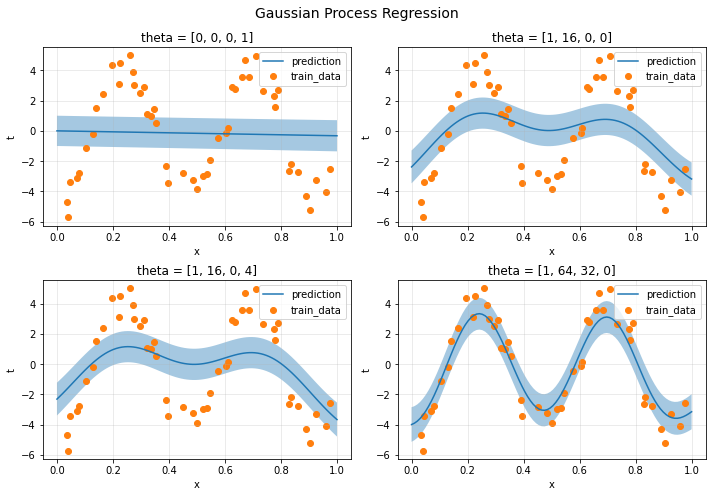

In [9]:
train_rmse = []
test_rmse = []
f, pltax = plt.subplots(2, 2, figsize = (10, 7))
pltax = pltax.flatten()  

for i in range(len(theta[0])):
    c_inv = np.linalg.inv(exp_kernel(theta[i], train_x, train_x) + beta_inv * np.identity(len(train_x)))

    for j in range(len(x)):
        k = exp_kernel(theta[i], train_x, x[j])
        y[j] = (k.dot(c_inv)).dot(train_t)

        C = exp_kernel(theta[i], x[j], x[j]) + beta_inv
        std[j] = np.sqrt(C - np.linalg.multi_dot([k.T, c_inv, k]))
    
    # train
    train_y = np.empty(len(train_x))
    for m in range(len(train_x)):
        k = exp_kernel(theta[i], train_x, train_x[m])
        train_y[m] = (k.dot(c_inv)).dot(train_t)
    train_rmse.append(rmse(train_y, train_t))
    
    # test
    test_y = np.empty(len(test_x))
    for n in range(len(test_x)):
        k = exp_kernel(theta[i], train_x, test_x[n])
        test_y[n] = (k.dot(c_inv)).dot(train_t)
    test_rmse.append(rmse(test_y, test_t))
    
    pltax[i].set_title(f'theta = {theta[i]}')
    pltax[i].grid('grey', alpha = 0.3)
    pltax[i].plot(x, y, label = 'prediction')
    pltax[i].fill_between(x, y + std, y - std, alpha = 0.4)
    pltax[i].scatter(train_x, train_t, label = 'train_data')
    pltax[i].set_xlabel("x")
    pltax[i].set_ylabel("t", rotation = 90)
    pltax[i].legend()

f.suptitle('Gaussian Process Regression', size = 14)
f.tight_layout()
f.subplots_adjust(top = 0.9)
plt.show();

In [10]:
rmse_table = PrettyTable()
rmse_table.add_column("theta", theta)
rmse_table.add_column("train_rmse", train_rmse)
rmse_table.add_column("test_rmse", test_rmse)
print(rmse_table)

+----------------+--------------------+--------------------+
|     theta      |     train_rmse     |     test_rmse      |
+----------------+--------------------+--------------------+
|  [0, 0, 0, 1]  |  3.12920142712342  | 3.3443986716914167 |
| [1, 16, 0, 0]  | 2.4239277450370538 | 2.6680512968156247 |
| [1, 16, 0, 4]  | 2.4105761899183507 | 2.656997541971028  |
| [1, 64, 32, 0] | 1.0428862504986347 | 1.1627584092659544 |
+----------------+--------------------+--------------------+


#### Automatic Relevance Determination

In [11]:
def partial(C_inv, C_dev, t):
    return (-np.trace(np.dot(C_inv, C_dev)) + np.linalg.multi_dot([t.T, C_inv, C_dev, C_inv, t])) / 2

In [12]:
param = [[1, 16, 32, 0]]
partial_ln = [0, 0, 0, 0]
learning_rate = 0.0001
p_lnp = [0, 0, 0, 0]

In [13]:
while True:
    c_inv = np.linalg.inv(exp_kernel(param[-1], train_x, train_x) + beta_inv * np.identity(len(train_x)))

    # update parameters
    partial_ln[0] = partial(c_inv, np.exp(-0.5 * param[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    partial_ln[1] = partial(c_inv, param[-1][0] * -0.5 * np.subtract.outer(train_x, train_x)**2 * np.exp(-0.5 * param[-1][1] * np.subtract.outer(train_x, train_x)**2), train_t)
    partial_ln[2] = partial(c_inv, np.full([len(train_x), len(train_x)], 1), train_t)
    partial_ln[3] = partial(c_inv, np.multiply.outer(train_x, train_x), train_t)
    
    for i in range(4):
        p_lnp[i] = -0.5 * np.trace(c_inv.dot(partial_ln[i])) + 0.5 * train_t.T.dot(c_inv).dot(partial_ln[i]).dot(c_inv).dot(train_t)
        
    param.append([p + learning_rate * dev for p, dev in zip(param[-1], p_lnp)])
    
    if np.max(np.abs(p_lnp)) < 6:
        break

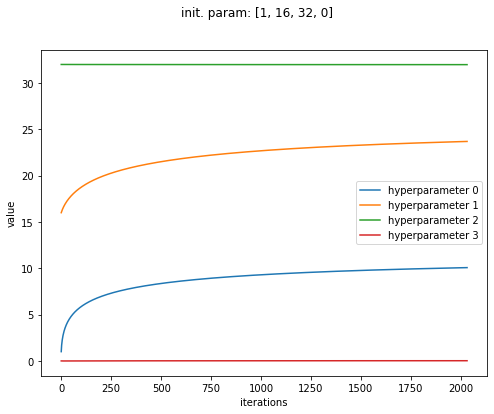

In [14]:
params = np.array(param)

plt.figure(figsize = (8, 6))
plt.suptitle(f"init. param: {param[0]}")
plt.plot(params[:, 0], label = 'hyperparameter 0')
plt.plot(params[:, 1], label = 'hyperparameter 1')
plt.plot(params[:, 2], label = 'hyperparameter 2')
plt.plot(params[:, 3], label = 'hyperparameter 3')
plt.legend()
plt.xlabel("iterations")
plt.ylabel("value", rotation = 90)
plt.show();

the best combination for the dataset

In [15]:
param[-1]

[10.07024840289998,
 23.69111071245117,
 31.981208768043377,
 0.020770187622768103]

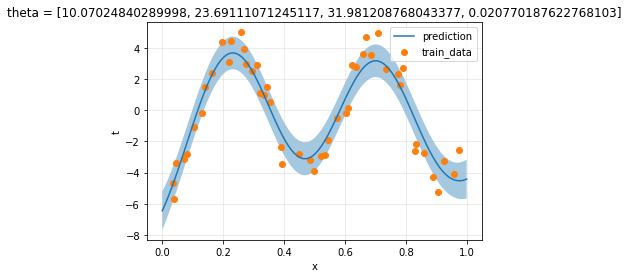

In [16]:
train_rmse_best = []
test_rmse_best = []

c_inv = np.linalg.inv(exp_kernel(param[-1], train_x, train_x) + beta_inv * np.identity(len(train_x)))

for j in range(len(x)):
    k = exp_kernel(param[-1], train_x, x[j])
    y[j] = (k.dot(c_inv)).dot(train_t)

    C = exp_kernel(param[-1], x[j], x[j]) + beta_inv
    std[j] = np.sqrt(C - np.linalg.multi_dot([k.T, c_inv, k]))

# train
train_y = np.empty(len(train_x))
for m in range(len(train_x)):
    k = exp_kernel(param[-1], train_x, train_x[m])
    train_y[m] = (k.dot(c_inv)).dot(train_t)
train_rmse_best.append(rmse(train_y, train_t))

# test
test_y = np.empty(len(test_x))
for n in range(len(test_x)):
    k = exp_kernel(param[-1], train_x, test_x[n])
    test_y[n] = (k.dot(c_inv)).dot(train_t)
test_rmse_best.append(rmse(test_y, test_t))

plt.title(f'theta = {param[-1]}')
plt.grid('grey', alpha = 0.3)
plt.plot(x, y, label = 'prediction')
plt.fill_between(x, y + std, y - std, alpha = 0.4)
plt.scatter(train_x, train_t, label = 'train_data')
plt.xlabel("x")
plt.ylabel("t", rotation = 90)
plt.legend()

plt.show();

In [17]:
rmse_table = PrettyTable()
rmse_table.add_column("theta", [param[-1]])
rmse_table.add_column("train_rmse", train_rmse_best)
rmse_table.add_column("test_rmse", test_rmse_best)
print(rmse_table)

+----------------------------------------------------------------------------------+--------------------+--------------------+
|                                      theta                                       |     train_rmse     |     test_rmse      |
+----------------------------------------------------------------------------------+--------------------+--------------------+
| [10.07024840289998, 23.69111071245117, 31.981208768043377, 0.020770187622768103] | 0.9827774028851929 | 1.1880952742588942 |
+----------------------------------------------------------------------------------+--------------------+--------------------+


### Support Vector Machine

In [18]:
downloaded = drive.CreateFile({'id':"1R40Oh-o2gx_RIK2kRTAm8DMMaaz_zPkv"})
downloaded.GetContentFile('x_train.csv')
train_x = pd.read_csv('x_train.csv', header = None).values

downloaded = drive.CreateFile({'id':"1H3xkn7QMX41asRTd5Jz-sQqxFFtTnoGX"})
downloaded.GetContentFile('t_train.csv')
train_t = pd.read_csv('t_train.csv', header = None).values.squeeze()

In [19]:
def PCA(x, n, eig_vec, eig_val):
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(len(eig_val))]
    eig_pairs.sort(key = lambda x: x[0], reverse = True)
    w = np.array([eig_pairs[i][1] for i in range(n)], dtype = 'float32')
    return x.dot(w.T)

In [20]:
covariance_train = np.cov(train_x.T)
eig_val, eig_vec = np.linalg.eig(covariance_train)
eig_val = np.abs(eig_val)

train_x = PCA(train_x, 2, eig_vec, eig_val)

mean = train_x.mean(axis = 0)
std = train_x.std(axis = 0)
train_x = (train_x - mean) / std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [21]:
def get_index(t):
    idx_0 = np.where(t == 0)
    idx_1 = np.where(t == 1)
    idx_2 = np.where(t == 2)
    return idx_0, idx_1, idx_2

In [22]:
def make_labels():
    label = ((0, 1), (0, 2), (1, 2))
    t01 = np.concatenate((np.full([100], 1), np.full([100], -1), np.zeros(100)))
    t02 = np.concatenate((np.full([100], 1), np.zeros(100), np.full([100], -1)))
    t12 = np.concatenate((np.zeros(100), np.full([100], 1), np.full([100], -1)))
    return label, t01, t02, t12

In [23]:
def get_w_b(a, t, x, n):
    if n == 1:
        phi_x = x
    elif n == 2:
        phi_x = np.array([x.T[0] ** 2, np.sqrt(2) * x.T[0] * x.T[1], x.T[1] ** 2]).T

    at = a * t
    w = at.dot(phi_x)
    idx_s = np.where(a != 0)[0]
    idx_m = np.where(np.logical_and(0 < a, a < 1))[0]
    
    if len(idx_m) == 0:
        b = -1
    else:
        b = np.sum(t[idx_m]) - np.sum(np.linalg.multi_dot([at[idx_s], phi_x[idx_s], phi_x[idx_m].T]))
        b /= len(idx_m)
    return w, b

In [24]:
def predict(W, B, x, label):
    phi_x = x
    pred = np.empty(len(phi_x))
    for i in range(len(phi_x)):
        cand = []
        for w, b, lab in zip(W, B, label):
            y = w.dot(phi_x[i]) + b
            if y > 0:
                cand.append(lab[0])
            else:
                cand.append(lab[1])
        pred[i] = Counter(cand).most_common(1)[0][0]
    return pred

In [25]:
def make_param(alphas, train_x, n):
    a01 = np.concatenate((alphas[:200, 0], np.zeros(100)))
    a02 = np.concatenate((alphas[:100, 1], np.zeros(100), alphas[200:, 0]))
    a12 = np.concatenate((np.zeros(100), alphas[100:, 1]))

    w01, b01 = get_w_b(a01, t01, train_x, n)
    w02, b02 = get_w_b(a02, t02, train_x, n)
    w12, b12 = get_w_b(a12, t12, train_x, n)
    return (w01, w02, w12), (b01, b02, b12)

In [26]:
def get_mesh(x, y):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    return xx, yy

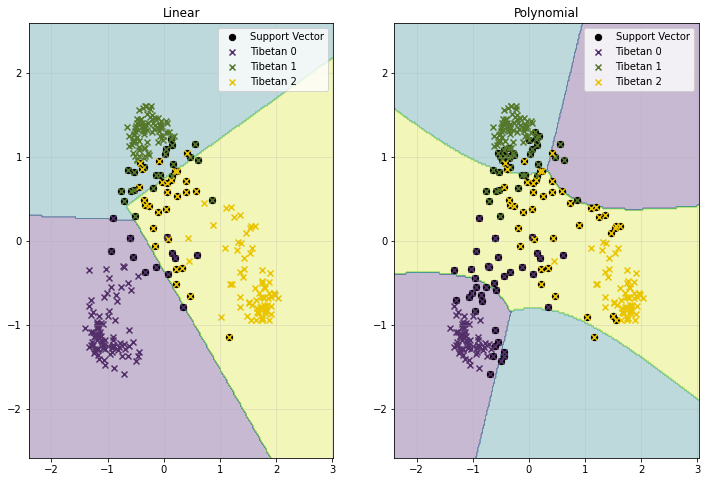

In [27]:
idx_0, idx_1, idx_2 = get_index(train_t)
label, t01, t02, t12 = make_labels()

'''
Linear Kernel
'''
# get coefficients
clf = SVC(kernel = 'linear', decision_function_shape = 'ovo')
clf.fit(train_x, train_t)
coef = np.abs(clf.dual_coef_)
sv_idx = clf.support_

alphas = np.zeros([len(train_x), 2])
alphas[sv_idx] = coef.T

W, B = make_param(alphas, train_x, 1)

X, Y = train_x[:, 0], train_x[:, 1]
xx, yy = get_mesh(X, Y)
Z = predict(W, B, np.column_stack((xx.flatten(), yy.flatten())), label).reshape(xx.shape)

fig, sub = plt.subplots(1, 2, figsize = (12, 8))

sub[0].contourf(xx, yy, Z, cmap = plt.cm.viridis, alpha = 0.3)
sub[0].scatter(X[sv_idx], Y[sv_idx], c = 'black', s = 40, facecolors = 'none', label = 'Support Vector')
sub[0].scatter(X[idx_0], Y[idx_0], c = '#54306b', marker = 'x', label = 'Tibetan 0')
sub[0].scatter(X[idx_1], Y[idx_1], c = '#56782c', marker = 'x', label = 'Tibetan 1')
sub[0].scatter(X[idx_2], Y[idx_2], c = '#ebc400', marker = 'x', label = 'Tibetan 2')
sub[0].legend()
sub[0].grid('grey', alpha = 0.3)
sub[0].set_xlim(xx.min(), xx.max())
sub[0].set_ylim(yy.min(), yy.max())
sub[0].set_title('Linear')

'''
Polynomial Kernel
'''
# get coefficients
clf2 = SVC(kernel = 'poly', degree = 2, decision_function_shape = 'ovo')
clf2.fit(train_x, train_t)
coef = np.abs(clf2.dual_coef_)
sv_idx = clf2.support_

alphas = np.zeros([len(train_x), 2])
alphas[sv_idx] = coef.T

W, B = make_param(alphas, train_x, 2)

X, Y = train_x[:, 0], train_x[:, 1]
xx, yy = get_mesh(X, Y)
Z = predict(W, B, np.vstack((xx.ravel() ** 2, np.sqrt(2) * xx.ravel() * yy.ravel(), yy.ravel() ** 2)).T, label).reshape(xx.shape)

sub[1].contourf(xx, yy, Z, cmap = plt.cm.viridis, alpha = 0.3)
sub[1].scatter(X[sv_idx], Y[sv_idx], c = 'black', s = 40, facecolors = 'none', label = 'Support Vector')
sub[1].scatter(X[idx_0], Y[idx_0], c = '#54306b', marker = 'x', label = 'Tibetan 0')
sub[1].scatter(X[idx_1], Y[idx_1], c = '#56782c', marker = 'x', label = 'Tibetan 1')
sub[1].scatter(X[idx_2], Y[idx_2], c = '#ebc400', marker = 'x', label = 'Tibetan 2')
sub[1].legend()
sub[1].grid('grey', alpha = 0.3)
sub[1].set_xlim(xx.min(), xx.max())
sub[1].set_ylim(yy.min(), yy.max())
sub[1].set_title('Polynomial')

plt.show();

### Gaussian Mixture Model

In [28]:
downloaded = drive.CreateFile({'id':"1wx6lhUcqtZ7ya5KeiSdB7g-mFMSeZAo9"})
downloaded.GetContentFile('imghw3.jpg')
img = cv2.imread('imghw3.jpg')
img = (img / 255.).reshape(-1, 3)

In [29]:
def segmentation(img, K, epoch):
    # K-means
    mu = img[np.random.randint(len(img), size = K)]
    gamma = np.full([len(img)], K)
    
    for i in range(epoch):
        dist = np.sum((img[:, None] - mu) ** 2, axis = 2) 
        new_gamma = np.argmin(dist, axis = 1)
        
        if np.array_equiv(gamma, new_gamma):
            break
        else:
            gamma = new_gamma

        for j in range(K):
            data_k = img[np.where(gamma == j)]
            if len(data_k) == 0:
                mu[j] = np.random.rand(3)
            else:
                mu[j] = np.mean(data_k, axis = 0)

    km_img = np.round(mu[gamma.astype('int')] * 255)
    
    kmean_table = PrettyTable()
    kmean_table.add_column("K-Means mean value", range(K))
    kmean_table.add_column("r", np.round(mu[:, 2] * 255).astype('int'))
    kmean_table.add_column("g", np.round(mu[:, 1] * 255).astype('int'))
    kmean_table.add_column("b", np.round(mu[:, 0] * 255).astype('int'))

    # GMM
    pi = np.unique(gamma, return_counts = True)[1] / len(gamma)
    sigma = np.array([np.cov(img[np.where(gamma == i)].T) for i in range(K)])
    p_x = np.array([multivariate_normal.pdf(img, mean = mu[i], cov = sigma[i]) * pi[i] for i in range(K)])
    
    L = []
    L.append(np.sum(np.log(np.sum(p_x, axis = 0))))
    
    for j in range(epoch):
        # E step
        gamma = (p_x / np.sum(p_x, axis = 0)).T
        
        # M step
        Nk = np.sum(gamma, axis = 0)
        new_mu = np.sum(img[:, np.newaxis] * gamma[:, :, np.newaxis], axis = 0) / Nk[:, np.newaxis]
        for k in range(K):
            sigma[k] = ((img - new_mu[k]) * gamma[:, k, None]).T.dot(img - new_mu[k]) / Nk[k]
        pi = Nk / len(img)
        
        # evaluate
        for l in range(K):
            try:
                p_x[l, :] = multivariate_normal.pdf(img, mean = new_mu[l], cov = sigma[l]) * pi[l]
            except np.linalg.linalg.LinAlgError:
                new_mu[l] = np.random.rand(3)
                tmp = np.random.rand(3, 3)
                sigma[l] = tmp.T.dot(tmp)
                p_x[l, :] = multivariate_normal.pdf(img, mean = new_mu[l], cov = sigma[l]) * pi[l]
                
        L.append(np.sum(np.log(np.sum(p_x, axis = 0))))
    
    gamma = np.argmax(p_x, axis = 0)
    GMM_img = np.round(new_mu[gamma] * 255)

    GMM_table = PrettyTable()
    GMM_table.add_column("GMM mean value", range(K))
    GMM_table.add_column("r", np.round(new_mu[:, 2] * 255).astype('int'))
    GMM_table.add_column("g", np.round(new_mu[:, 1] * 255).astype('int'))
    GMM_table.add_column("b", np.round(new_mu[:, 0] * 255).astype('int'))

    return km_img, GMM_img, L, kmean_table, GMM_table

K = 3 (K-means)
+--------------------+-----+-----+-----+
| K-Means mean value |  r  |  g  |  b  |
+--------------------+-----+-----+-----+
|         0          |  74 |  67 |  53 |
|         1          | 133 | 126 | 105 |
|         2          | 194 | 196 | 182 |
+--------------------+-----+-----+-----+
K = 3 (GMM)
+----------------+-----+-----+-----+
| GMM mean value |  r  |  g  |  b  |
+----------------+-----+-----+-----+
|       0        |  81 |  68 |  59 |
|       1        | 136 | 124 |  88 |
|       2        | 127 | 130 | 122 |
+----------------+-----+-----+-----+


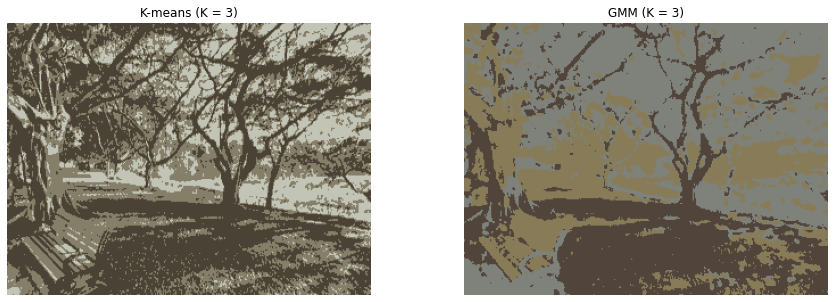

K = 5 (K-means)
+--------------------+-----+-----+-----+
| K-Means mean value |  r  |  g  |  b  |
+--------------------+-----+-----+-----+
|         0          | 215 | 218 | 209 |
|         1          |  59 |  52 |  40 |
|         2          |  94 |  86 |  70 |
|         3          | 170 | 168 | 148 |
|         4          | 133 | 125 | 104 |
+--------------------+-----+-----+-----+
K = 5 (GMM)
+----------------+-----+-----+-----+
| GMM mean value |  r  |  g  |  b  |
+----------------+-----+-----+-----+
|       0        | 160 | 165 | 164 |
|       1        |  80 |  66 |  59 |
|       2        |  73 |  70 |  59 |
|       3        | 141 | 150 | 112 |
|       4        | 126 | 111 |  86 |
+----------------+-----+-----+-----+


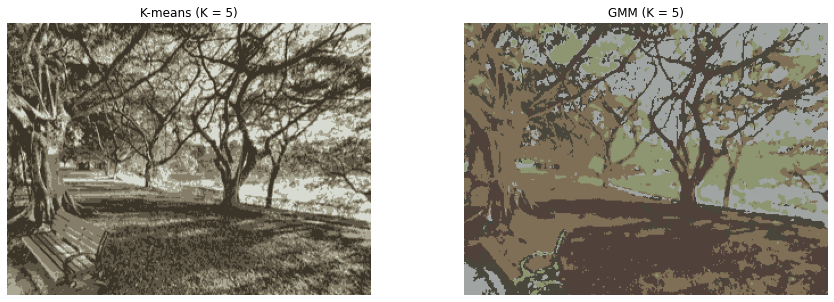

K = 7 (K-means)
+--------------------+-----+-----+-----+
| K-Means mean value |  r  |  g  |  b  |
+--------------------+-----+-----+-----+
|         0          | 140 | 133 | 114 |
|         1          |  80 |  73 |  59 |
|         2          | 110 | 103 |  83 |
|         3          |  52 |  45 |  33 |
|         4          | 188 | 174 | 125 |
|         5          | 165 | 174 | 173 |
|         6          | 220 | 223 | 216 |
+--------------------+-----+-----+-----+
K = 7 (GMM)
+----------------+-----+-----+-----+
| GMM mean value |  r  |  g  |  b  |
+----------------+-----+-----+-----+
|       0        | 157 | 145 | 118 |
|       1        |  68 |  66 |  54 |
|       2        | 115 |  99 |  76 |
|       3        |  78 |  65 |  58 |
|       4        | 129 | 132 |  79 |
|       5        | 122 | 127 | 128 |
|       6        | 184 | 189 | 186 |
+----------------+-----+-----+-----+


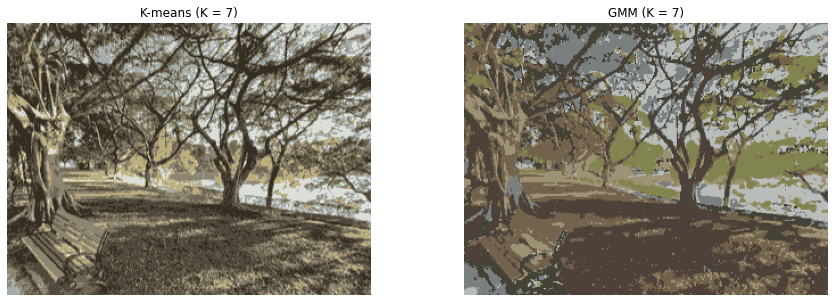

K = 10 (K-means)
+--------------------+-----+-----+-----+
| K-Means mean value |  r  |  g  |  b  |
+--------------------+-----+-----+-----+
|         0          |  69 |  61 |  49 |
|         1          | 155 | 163 | 161 |
|         2          | 192 | 177 | 127 |
|         3          | 195 | 200 | 190 |
|         4          | 152 | 136 | 103 |
|         5          |  90 |  83 |  68 |
|         6          | 232 | 235 | 231 |
|         7          | 121 | 129 | 127 |
|         8          |  44 |  38 |  25 |
|         9          | 116 | 107 |  85 |
+--------------------+-----+-----+-----+
K = 10 (GMM)
+----------------+-----+-----+-----+
| GMM mean value |  r  |  g  |  b  |
+----------------+-----+-----+-----+
|       0        |  78 |  65 |  58 |
|       1        | 161 | 169 | 168 |
|       2        | 129 | 133 |  78 |
|       3        | 158 | 172 | 161 |
|       4        | 152 | 138 | 114 |
|       5        |  85 |  80 |  66 |
|       6        | 229 | 230 | 230 |
|       7        | 109 | 1

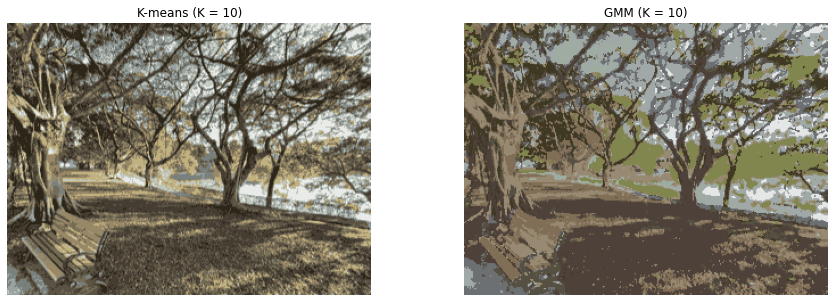

In [30]:
likelihood = []
n_list = [3, 5, 7, 10]

for i in n_list:
    km_img, GMM_img, L, kmean_table, GMM_table = segmentation(img, i, 100)
    likelihood.append(L)
    print("K =", i, "(K-means)")
    print(kmean_table)
    print("K =", i, "(GMM)")
    print(GMM_table)

    fig, ax = plt.subplots(1, 2, figsize = (15, 5))

    km_jpg = km_img.reshape(239, 320, -1).astype("int")
    km_jpg = km_jpg[:, :, ::-1]
    ax[0].set_title("K-means (K = %d)" % i)
    ax[0].imshow(km_jpg)
    ax[0].axis('off')

    GMM_jpg = GMM_img.reshape(239, 320, -1).astype("int")
    GMM_jpg = GMM_jpg[:, :, ::-1]
    ax[1].set_title("GMM (K = %d)" % i)
    ax[1].imshow(GMM_jpg)
    ax[1].axis('off')

    plt.show();

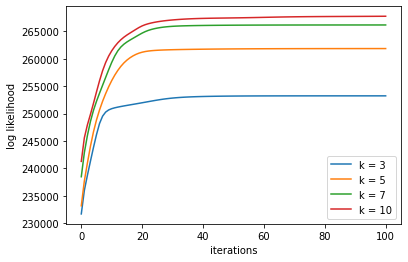

In [31]:
for i in range(len(n_list)):
    plt.plot(range(0, 101), likelihood[i])

plt.legend(["k = 3", "k = 5", "k = 7", "k = 10"])
plt.xlabel("iterations")
plt.ylabel("log likelihood", rotation = 90)
plt.show();